# Movies Recommender System

My Capstone Project on Movie Data Analysis and Recommendation Systems. In my first notebook ( [The Story of Film](https://www.kaggle.com/rounakbanik/the-story-of-film/) ), I attempted at narrating the story of film by performing an extensive exploratory data analysis on Movies Metadata collected from TMDB. I also built two extremely minimalist predictive models to predict movie revenue and movie success and visualise which features influence the output (revenue and success respectively).

In this notebook, I will attempt at implementing a few recommendation algorithms (content based, popularity based and collaborative filtering) and try to build an ensemble of these models to come up with our final recommendation system. With us, we have two MovieLens datasets.

* **The Full Dataset:** Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.
* **The Small Dataset:** Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

I will build a Simple Recommender using movies from the *Full Dataset* whereas all personalised recommender systems will make use of the small dataset (due to the computing power I possess being very limited). As a first step, I will build my simple recommender system.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [2]:
!pip install scikit-surprise==1.0.6 # Install an older version of scikit-surprise
from surprise import Reader, Dataset, SVD, evaluate
# Now you can import 'evaluate' directly from 'surprise'

In [3]:
!pip install scikit-surprise

## Simple Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre.

In [6]:
md = pd. read_csv('/content/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

I use the TMDB Ratings to come up with our **Top Movies Chart.** I will use IMDB's *weighted rating* formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

In [8]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [9]:
m = vote_counts.quantile(0.95)
m

434.0

In [10]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [11]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least **434 votes** on TMDB. We also see that the average rating for a movie on TMDB is **5.244** on a scale of 10. **2274** Movies qualify to be on our chart.

In [12]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [14]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

In [15]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


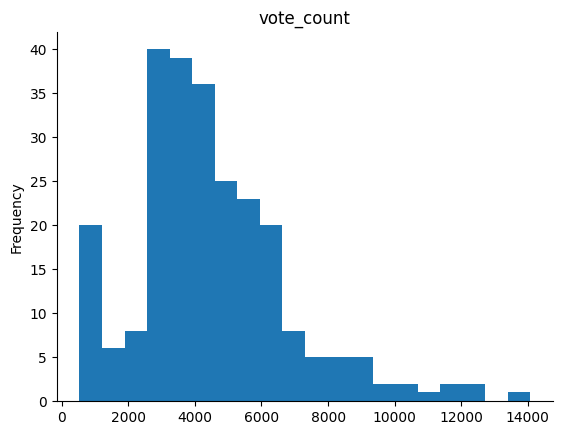

In [16]:
# @title vote_count

from matplotlib import pyplot as plt
qualified['vote_count'].plot(kind='hist', bins=20, title='vote_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

We see that three Christopher Nolan Films, **Inception**, **The Dark Knight** and **Interstellar** occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the **85th** percentile instead of 95.

In [17]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [18]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

Let us see our method in action by displaying the Top 15 Romance Movies (Romance almost didn't feature at all in our Generic Top Chart despite  being one of the most popular movie genres).

### Top Romance Movies

In [19]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


The top romance movie according to our metrics is Bollywood's **Dilwale Dulhania Le Jayenge**. This Shahrukh Khan starrer also happens to be one of my personal favorites.

## Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

For instance, consider a person who loves *Dilwale Dulhania Le Jayenge*, *My Name is Khan* and *Kabhi Khushi Kabhi Gham*. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as **Content Based Filtering.**

I will build two Content Based Recommenders based on:
* Movie Overviews and Taglines
* Movie Cast, Crew, Keywords and Genre

Also, as mentioned in the introduction, I will be using a subset of all the movies available to us due to limiting computing power available to me.

In [20]:
links_small = pd.read_csv('/content/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [21]:
md = md.drop([19730, 29503, 35587])

In [22]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [23]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

We have **9099** movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

### Movie Description Based Recommender

Let us first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.

In [24]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [26]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english') # Change min_df to 1 or a higher value
tfidf_matrix = tf.fit_transform(smd['description'])

In [27]:
tfidf_matrix.shape

(9099, 268124)

#### Cosine Similarity

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [28]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [29]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [30]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [31]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are.

In [32]:
get_recommendations('The Godfather').head(10)

,title
973,The Godfather: Part II
8387,The Family
3509,Made
4196,Johnny Dangerously
29,Shanghai Triad
5667,Fury
2412,American Movie
1582,The Godfather: Part III
4221,8 Women
2159,Summer of Sam


In [33]:
get_recommendations('The Dark Knight').head(10)

,title
7931,The Dark Knight Rises
132,Batman Forever
1113,Batman Returns
8227,"Batman: The Dark Knight Returns, Part 2"
7565,Batman: Under the Red Hood
524,Batman
7901,Batman: Year One
2579,Batman: Mask of the Phantasm
2696,JFK
8165,"Batman: The Dark Knight Returns, Part 1"


We see that for **The Dark Knight**, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of Nolan and would hate **Batman Forever** and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than **Overview** and **Tagline**. In the next subsection, we will build a more sophisticated recommender that takes **genre**, **keywords**, **cast** and **crew** into consideration.

### Metadata Based Recommender

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [ ]:
credits = pd.read_csv('/content/credits.csv')
keywords = pd.read_csv('/content/keywords.csv')

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [ ]:
md.shape

(45463, 25)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the *feel* of the movie.
2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

My approach to building the recommender is going to be extremely *hacky*. What I plan on doing is creating a metadata dump for every movie which consists of **genres, director, main actors and keywords.** I then use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:
1. **Strip Spaces and Convert to Lowercase** from all our features. This way, our engine will not confuse between **Johnny Depp** and **Johnny Galecki.**
2. **Mention Director 3 times** to give it more weight relative to the entire cast.

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

#### Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as *Dogs* and *Dog* are considered the same.

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

I am much more satisfied with the results I get this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. I enjoyed watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **The Prestige** and **The Dark Knight Rises**.

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

Let me also get recommendations for another movie, **Mean Girls** which happens to be my girlfriend's favorite movie.

In [ ]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object

#### Popularity and Ratings

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that **Batman and Robin** has a lot of similar characters as compared to **The Dark Knight** but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


Let me also get the recommendations for **Mean Girls**, my girlfriend's favorite movie.

In [ ]:
improved_recommendations('Mean Girls')

,title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.709602
390,Dazed and Confused,588,7,1993,6.254682
8883,The DUFF,1372,6,2015,5.818541
3712,The Princess Diaries,1063,6,2001,5.781086
4763,Freaky Friday,919,6,2003,5.757786
6277,Just Like Heaven,595,6,2005,5.681521
6959,The Spiderwick Chronicles,593,6,2008,5.680901
7494,American Pie Presents: The Book of Love,454,5,2009,5.119690
7332,Ghosts of Girlfriends Past,716,5,2009,5.092422
7905,Mr. Popper's Penguins,775,5,2011,5.087912


Unfortunately, **Batman and Robin** does not disappear from our recommendation list. This is probably due to the fact that it is rated a 4, which is only slightly below average on TMDB. It certainly doesn't deserve a 4 when amazing movies like **The Dark Knight Rises** has only a 7. However, there is nothing much we can do about this. Therefore, we will conclude our Content Based Recommender section here and come back to it when we build a hybrid engine.

## Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

I will not be implementing Collaborative Filtering from scratch. Instead, I will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [39]:
reader = Reader()

In [40]:
ratings = pd.read_csv('/content/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [41]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [42]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8978
MAE:  0.6891
------------
Fold 2
RMSE: 0.8986
MAE:  0.6935
------------
Fold 3
RMSE: 0.8983
MAE:  0.6916
------------
Fold 4
RMSE: 0.8928
MAE:  0.6866
------------
Fold 5
RMSE: 0.8999
MAE:  0.6938
------------
------------
Mean RMSE: 0.8975
Mean MAE : 0.6909
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8977687164627814,
                             0.898562480234737,
                             0.8983216244944201,
                             0.8927838588660458,
                             0.8999268276905423],
                            'mae': [0.689130098088479,
                             0.6935035817145637,
                             0.691570104151326,
                             0.6866103696194054,
                             0.6937571176344504]})

We get a mean **Root Mean Sqaure Error** of 0.8963 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [43]:
trainset = data.build_full_trainset()
svd.train(trainset)

Let us pick user 5000 and check the ratings s/he has given.

In [44]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [45]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7572823403125666, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.686**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender


In this section, I will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [46]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [49]:
id_map = pd.read_csv('/content/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [50]:
indices_map = id_map.set_index('id')

In [51]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [52]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
2059,The Matrix,9079.0,7.9,1999,603,3.328445
975,A Grand Day Out,199.0,7.4,1990,530,3.263999
6105,A Trip to the Moon,314.0,7.9,1902,775,3.073868
1898,A Simple Plan,191.0,6.9,1998,10223,3.040970
2910,Pandora and the Flying Dutchman,19.0,6.5,1951,38688,2.886387
4804,Avalon,93.0,6.8,2001,10881,2.880931
5044,The Men,18.0,6.5,1950,1882,2.836463
3015,House Party 2,22.0,4.7,1991,16096,2.798903
5229,Ambush,13.0,6.3,1999,49320,2.792041
4643,"Heaven Knows, Mr. Allison",27.0,6.8,1957,37103,2.765450


In [53]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
6105,A Trip to the Moon,314.0,7.9,1902,775,3.516679
975,A Grand Day Out,199.0,7.4,1990,530,3.347686
3015,House Party 2,22.0,4.7,1991,16096,3.243663
7460,Green Zone,730.0,6.4,2010,22972,3.237762
4804,Avalon,93.0,6.8,2001,10881,3.209160
3018,Rocketship X-M,15.0,5.1,1950,37744,3.119386
5229,Ambush,13.0,6.3,1999,49320,3.091519
1898,A Simple Plan,191.0,6.9,1998,10223,3.080067
538,Hellraiser: Bloodline,111.0,4.9,1996,8766,3.065180
3360,The Dish,62.0,6.6,2000,5257,3.050769


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Conclusion

In this notebook, I have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender:** This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. **Content Based Recommender:** We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
3. **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
4. **Hybrid Engine:** We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.
